In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
class GRUVAE(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, latent_dim, vocab_size, sos_token, num_layers):
        super(GRUVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.sos_token = sos_token

        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        self.encoder_style = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True) # (N,B,H) N batches, B sequence length, H input dim
        self.encoder_content = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fcmu_s = nn.Linear(hidden_dim, 8)
        self.fcvar_s = nn.Linear(hidden_dim, 8)
        self.fcmu_c = nn.Linear(hidden_dim, 128)
        self.fcvar_c = nn.Linear(hidden_dim, 128)

        self.fc_s = nn.Linear(hidden_dim, 8)
        self.fc_c = nn.Linear(hidden_dim, 128)
        self.fclatent = nn.Linear(hidden_dim, latent_dim)

        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.GRU(self.embedding_dim, latent_dim, num_layers,batch_first=True)
        self.fc_out = nn.Linear(latent_dim, vocab_size)

    def forward(self, x):
        embedded_input = self.embedding(x)
        #out = self.layer_norm(embedded_input)
        _, hn = self.encoder_style(embedded_input)
        #_, hn_c = self.encoder_content(out)
        mu_s = self.fcmu_s(hn)
        logvar_s = self.fcvar_s(hn)
        mu_c = self.fcmu_c(hn)
        logvar_c = self.fcvar_c(hn)

        style = self.reparametrization(mu_s, logvar_s)
        content = self.reparametrization(mu_c, logvar_c)
        z = torch.cat((style,content), dim = 2)

        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)

        output = []
        for t in range(decoder_input.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,t,:].unsqueeze(1), z)
            output.append(outputs)
        
        reconstructed_sequence = torch.cat(output, dim=1)
        reconstructed_sequence = self.fc_out(reconstructed_sequence)

        return reconstructed_sequence[:,1:,:], style, content, mu_s, logvar_s, mu_c, logvar_c


    def reparametrization(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    '''def style_transfer(self, x, new_style):
        embedded_input = self.embedder(x)
        out = self.layer_norm(embedded_input)
        _, hn = self.encoder(out)

        mu_s = self.fcmu_s(hn)
        log_var_s = self.fcvar_s(hn)
        mu_c = self.fcmu_c(hn)
        log_var_c = self.fcvar_c(hn)

        z_s = self.reparametrization(mu_s,log_var_s)
        z_c = self.reparametrization(mu_c,log_var_c)

        z = torch.cat((new_style,z_c), dim = 2)

        decoder_input = self.fc(z)

        sos_token = self.sos_token.repeat(x.size(0), x.size(1),1)
        dec_output,_ = self.decoder(sos_token, decoder_input)
        recon_out = self.fc_out(dec_output)

        return recon_out'''

In [5]:
class StyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(StyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),1))
        
    def forward(self,x):
        out = self.mlp(x)
        out = torch.sigmoid(out)
        return out.view(out.shape[1])

In [6]:
class AdvStyleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(AdvStyleClassifier, self).__init__()
        self.input_dim = input_dim
        self.mlp = nn.Sequential(nn.Linear(input_dim,int(input_dim*0.5)),
                                  nn.ReLU(),
                                  nn.Linear(int(input_dim*0.5),1))
        
    def forward(self,x):
        out = self.mlp(x)
        out = torch.sigmoid(out)
        return out.view(out.shape[1])

In [7]:
class ContentClassifier(nn.Module):
    def __init__(self, input_dim, vocab_size):
        super(ContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.fc = nn.Linear(input_dim,vocab_size)
        
    def forward(self,x):
        out = self.fc(x)
        out = F.softmax(out,dim=2)
        return out.squeeze(0)

In [8]:
class AdvContentClassifier(nn.Module):
    def __init__(self, input_dim, vocab_size):
        super(AdvContentClassifier, self).__init__()
        self.input_dim = input_dim
        self.vocab_size = vocab_size
        self.fc = nn.Linear(input_dim,vocab_size)
        
    def forward(self,x):
        out = self.fc(x)
        out = F.softmax(out,dim=2)
        return out.squeeze(0)

# Train function

In [75]:
def vae_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c, l_s = 0.05, l_c = 0.05, loss_fn = nn.MSELoss(), cos = nn.CosineSimilarity(), CE = nn.CrossEntropyLoss()):
    #BCE = loss_fn(recon_x, x)
    #BCE = 1 - cos(recon_x,x).mean()
    BCE = CE(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))),x.view(-1))
    KLD_s = -0.5 * torch.sum(1 + logvar_s - mu_s.pow(2) - logvar_s.exp())
    KLD_c = -0.5 * torch.sum(1 + logvar_c - mu_c.pow(2) - logvar_c.exp())
    return BCE + l_s*KLD_s + l_c*KLD_c

In [10]:
def mul_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_mul_s = loss_fn(y_s, labels)

    return L_mul_s

In [11]:
def mul_c_loss(y_c, bow, loss_fn=nn.BCELoss()):
    L_mul_c = loss_fn(y_c, bow)

    return L_mul_c

In [12]:
def dis_s_loss(y_s, labels, loss_fn=nn.BCELoss()):
    L_dis_s = loss_fn(y_s, labels)

    return L_dis_s

In [13]:
def dis_c_loss(y_c, bow, loss_fn=nn.BCELoss()):
    L_dis_c = loss_fn(y_c, bow)

    return L_dis_c

In [14]:
def adv_s_loss(y_s, loss_fn=nn.BCELoss()):
    L_adv_s = loss_fn(y_s, y_s)

    return L_adv_s

In [15]:
def adv_c_loss(y_c, loss_fn = nn.BCELoss()):
    L_adv_c = loss_fn(y_c,y_c)

    return L_adv_c

In [20]:
def total_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow, l_muls=10, l_mulc=3, l_advs=1, l_advc=0.03):
    L_VAE = vae_loss(recon_x, x, mu_s, logvar_s, mu_c, logvar_c)
    L_muls = mul_s_loss(y_s, labels)
    L_mulc = mul_c_loss(y_c, bow)
    L_advs = adv_s_loss(y_s_given_c)
    L_advc = adv_c_loss(y_c_given_s)

    return L_VAE + l_muls*L_muls + l_mulc*L_mulc - l_advs*L_advs - l_advc*L_advc

In [60]:
def train_VAE(vae, style_classif, adv_style_classif, content_classif, adv_content_classif, train_loader, val_loader, num_epochs, vocab_size, lr = 4e-4):
    params_tot = list(vae.parameters()) + list(style_classif.parameters()) + list(content_classif.parameters())
    params_dis_s = list(adv_style_classif.parameters())
    params_dis_c = list(adv_content_classif.parameters())

    optimizer_tot = torch.optim.Adam(params_tot, lr = lr)
    optimizer_dis_s = torch.optim.Adam(params_dis_s, lr = lr)
    optimizer_dis_c = torch.optim.Adam(params_dis_c, lr = lr)

    average_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0
        
        #model.train()
        for  i, (data, bow, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.type(torch.FloatTensor)

            optimizer_tot.zero_grad()
            optimizer_dis_s.zero_grad()
            optimizer_dis_c.zero_grad()

            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
            
        
            predicted_adv_style = adv_style_classif(content)
            predicted_adv_style = predicted_adv_style.type(torch.FloatTensor)
        
    
            L_dis_s = dis_s_loss(predicted_adv_style, labels)

            L_dis_s.backward()
            optimizer_dis_s.step()

            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)


            predicted_adv_content = adv_content_classif(style)

            L_dis_c = dis_c_loss(predicted_adv_content, bow)

            L_dis_c.backward()
            optimizer_dis_c.step()


            reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
            

            y_s = style_classif(style)
            y_c = content_classif(content)
            y_s_given_c = adv_style_classif(content)
            y_c_given_s = adv_content_classif(style)

            reconstructed_sequence = torch.FloatTensor(reconstructed_sequence)
            
            #data = data.type(torch.FloatTensor)
            loss_tot = total_loss(reconstructed_sequence, data, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow)
            loss_tot.backward()
            train_loss += loss_tot.item()


            optimizer_tot.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss_tot.item() / len(data):.6f}')
        
        
        average_loss = train_loss / len(train_loader.dataset)
        #plt.plot(epoch+1,average_loss)
        print(f'====> Epoch: {epoch+1} Average loss: {average_loss:.4f}')
        average_losses.append(average_loss)

        with torch.no_grad():
            for i, (data, bow, labels) in enumerate(val_loader):
                data = data.to(device)
                labels = labels.type(torch.FloatTensor)

                reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c = vae(data)
                

                y_s = style_classif(style)
                y_c = content_classif(content)
                y_s_given_c = adv_style_classif(content)
                y_c_given_s = adv_content_classif(style)

                reconstructed_sequence = torch.FloatTensor(reconstructed_sequence)
                
                #data = data.type(torch.FloatTensor)
                val_loss_tot = total_loss(reconstructed_sequence, data, mu_s, logvar_s, mu_c, logvar_c, y_s, y_c, y_s_given_c, y_c_given_s, labels, bow)
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(data)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(data):.6f}')
            
            
        average_val_loss = val_loss / len(val_loader.dataset)
        #print(f'====> Epoch: {epoch+1} Average loss: {average_val_loss:.4f}')
        val_losses.append(average_val_loss)

    
    plt.plot(np.linspace(1,num_epochs,len(average_losses)), average_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    return average_losses

# è importantissimo

In [130]:
#nomeFile='divina_commedia.txt'
#nomeFile='malavoglia.txt'
#nomeFile = 'uno_nessuno_e_i_malavoglia.txt'
nomeFile = 'tutto_assieme.txt'

with open(nomeFile, 'r', encoding='utf-8') as f:
    text = f.read()

In [131]:
print(len(text.split()))
text.split()[:10]

203210


['nel',
 'mezzo',
 'del',
 'cammin',
 'di',
 'nostra',
 'vita',
 'mi',
 'ritrovai',
 'per']

In [22]:
def BoW(tensor, vocab_size, sequence_length):
    bow = torch.zeros(size = (tensor.shape[0],vocab_size))
    #BoW = [(data1[i] == num).sum().item()/data1.shape[1]  for i in range(data1.shape[0]) for num in data1[i] if BoW[i][torch.where(data1[i] == num)[0][0].item()]==0]

    for i in range(tensor.shape[0]):
        for num in tensor[i]:
            bow[i][num] = (tensor[i] == num).sum().item()/sequence_length

    return torch.FloatTensor(bow)

In [23]:
def divide_text(text, sequence_length):
    words = text.split()
    #words = text
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length))]  # range (0,len(words),8)
    #grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),2)]
    #grouped_words = [words[i] for i in range(0,len(words),19)]
    #grouped_words_2d = [sentence.split() for sentence in grouped_words]
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]
    return output_text

In [58]:
text_divided = divide_text(text, 19)
np.shape(text_divided)
text_divided[0]

['nel',
 'mezzo',
 'del',
 'cammin',
 'di',
 'nostra',
 'vita',
 'mi',
 'ritrovai',
 'per',
 'una',
 'selva',
 'oscura',
 'chè',
 'la',
 'diritta',
 'via',
 'era',
 'smarrita']

In [ ]:
word2vec = Word2Vec(text_divided, vector_size = 20248, window = 5, min_count=1, workers=4, epochs = 50)

In [36]:
def custom_dataset(file1 : str,file2 : str, sequence_length, embedding_dim, batch_size, training_fraction):

    with open(file1, 'r', encoding='utf-8') as f:
        text1 = f.read()


    with open(file2, 'r', encoding='utf-8') as f:
        text2 = f.read()

    text1 = '<sos> ' + text1 
    text = text1 + ' ' + text2
    divided_text = divide_text(text, sequence_length)

    #word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = int(sequence_length/2), min_count=1, workers=4)
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = 5, min_count=1, workers=4, epochs = 50)
    #word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=20)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    # Convert to PyTorch tensor
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)



    text1_divided = divide_text(text1, sequence_length)
    data1 = torch.LongTensor([[word2idx[char] for char in text1_divided[i]] for i in range(len(text1_divided))])


    text2_divided = divide_text(text2, sequence_length)
    data2 = torch.LongTensor([[word2idx[char] for char in text2_divided[i]] for i in range(len(text2_divided))])


    data1_train = data1[:int(training_fraction * data1.shape[0])]
    data1_val = data1[int(training_fraction * data1.shape[0]):]

    data2_train = data2[:int(training_fraction * data2.shape[0])]
    data2_val = data2[int(training_fraction * data2.shape[0]):]


    label0_train = torch.zeros(data1_train.shape[0])
    label0_val = torch.zeros(data1_val.shape[0])

    label1_train = torch.ones(data2_train.shape[0])
    label1_val = torch.ones(data2_val.shape[0])


    labels_train = torch.cat((label0_train, label1_train), dim = 0)
    labels_val = torch.cat((label0_val, label1_val), dim = 0)

    data_train = torch.cat((data1_train, data2_train), dim = 0)
    data_val = torch.cat((data1_val, data2_val), dim = 0)

    data_train = torch.LongTensor(data_train)
    labels_train = labels_train.type(torch.LongTensor)
    bow_train = BoW(data_train, vocab_size, sequence_length)

    dataset_train = TensorDataset(data_train, bow_train, labels_train)

    # Create a DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle=True)
    #dataloader_train = DataLoader(dataset_train, batch_size = batch_size)


    data_val = torch.LongTensor(data_val)
    labels_val = labels_val.type(torch.LongTensor)
    bow_val = BoW(data_val, vocab_size, sequence_length)

    dataset_val = TensorDataset(data_val, bow_val, labels_val)

    # Create a DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    #dataloader_val = DataLoader(dataset_val, batch_size = batch_size)


    style0_val = torch.LongTensor(data1_val)
    style1_val = torch.LongTensor(data2_val)
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_val, style1_val

In [37]:
sequence_length = 15
embedding_dim = 300
hidden_dim = 256
latent_dim = 136

In [38]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_val, style1_val = custom_dataset('divina_commedia.txt', 
                                                                                     'uno_nessuno_e_i_malavoglia.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = 32, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

len train loader:  381


In [ ]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, vocab_size, style0_val, style1_val = custom_dataset('divina_commedia.txt', 
                                                                                     'lo_cunto_de_li_cunti.txt', 
                                                                                     sequence_length, 
                                                                                     embedding_dim,
                                                                                     batch_size = 32, 
                                                                                     training_fraction = 0.9)
print('len train loader: ', len(train_loader))

In [39]:
vocab_size

20249

In [41]:
sos_token = torch.full((1,),word2idx['<sos>'])
sos_token = sos_token.type(torch.LongTensor)

In [76]:
vae = GRUVAE(embedding_matrix, hidden_dim, latent_dim, vocab_size, sos_token, num_layers = 1)

style_classif = StyleClassifier(8)
adv_style_classif = AdvStyleClassifier(128)
content_classif = ContentClassifier(128, vocab_size)
adv_content_classif = AdvContentClassifier(8, vocab_size)

In [77]:
vae_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
style_params = sum(p.numel() for p in style_classif.parameters() if p.requires_grad)
style_adv_params = sum(p.numel() for p in adv_style_classif.parameters() if p.requires_grad)
content_params = sum(p.numel() for p in content_classif.parameters() if p.requires_grad)
adv_content_params = sum(p.numel() for p in adv_content_classif.parameters() if p.requires_grad)
total_params =  vae_params + style_params + style_adv_params + content_params + adv_content_params
print('Total parameters: ', total_params)

Total parameters:  6788109


  0%|          | 0/3 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 0.2925


 33%|███▎      | 1/3 [01:44<03:28, 104.07s/it]

====> Epoch: 2 Average loss: 0.1692


 67%|██████▋   | 2/3 [03:29<01:44, 104.75s/it]

====> Epoch: 3 Average loss: 0.1379


100%|██████████| 3/3 [05:15<00:00, 105.20s/it]


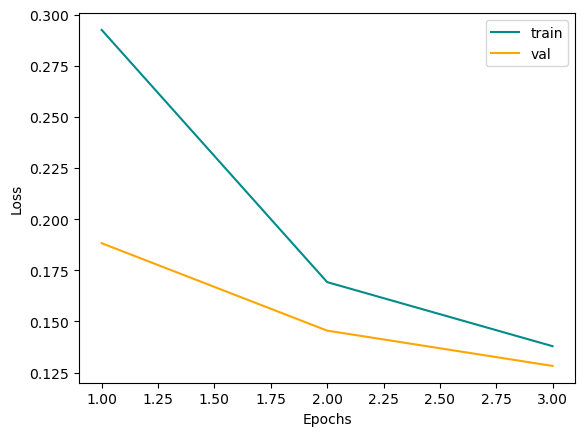

In [80]:
losses = train_VAE(vae,
                   style_classif,
                   adv_style_classif,
                   content_classif,
                   adv_content_classif,
                   train_loader,
                   val_loader,
                   num_epochs = 3,
                   vocab_size= vocab_size,
                   lr = 1e-3)

# Ricostruzione

In [84]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    reconstructed_sequence, style, content, mu_s, logvar_s, mu_c, logvar_c  = vae(prova)

indices = torch.argmax(reconstructed_sequence, dim=2)

ricostruzione = []
for i in range(prova.shape[1]):
    ricostruzione.append(idx2word[indices[0][i].item()])


if labels.item() == 0.0:
    stile = 'Dante'
else: 
    stile = 'Italiano'

style = style_classif(style)

print('Stile reale: ', stile)
print('Stile predetto: ', style[0].item())
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

Stile reale:  Dante
Stile predetto:  0.059713371098041534
Input sequence: 
 da un fulgore in che sua voglia venne a l alta fantasia qui mancò possa

Reconstructed sequence: 
 da un velo in che sua voglia venne a l alta sapienza qui eravate possa


In [143]:
for i ,(data,bow,label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
        boww = bow[0]

frase = [idx2word[prova[i].item()] for i in range(prova.shape[0])]


prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    reconstructed, embedded_input, z_s, z_c, mu_s, log_var_s, mu_c, log_var_c = vae(prova)

reconstructed = reconstructed.squeeze(0)
ricostruzione = []
for i in range(reconstructed.shape[0]):
    ricostruzione.append((word2vec.wv.most_similar(np.array(reconstructed[i]),topn=1)[0][0]))

if labels.item() == 0.0:
    stile = 'Dante'
else: 
    stile = 'Italiano'

style = style_classif(z_s)

print('Stile: ', stile)
print('Stile predetto: ', style[0].item())
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(ricostruzione))

Stile:  Dante
Stile predetto:  0.00020608442719094455
Input sequence: 
 l usanza sua come fec io per far migliori spegli ancor de li occhi chinandomi a l onda che si deriva perchè vi s immegli

Reconstructed sequence: 
 l usanza sua come fec io per far migliori spegli ancor de li occhi chinandomi a l onda che si deriva perchè vi s immegli


In [50]:
style0_val.shape

torch.Size([1270, 25])

In [51]:
for i, sentence in enumerate(style0_val):
    if i ==0:
        print(sentence.shape)


torch.Size([25])


# Style transfer

In [151]:
with torch.no_grad():
    reconstructed, embedded_input, z_s, z_c, mu_s, log_var_s, mu_c, log_var_c = vae(style1_val)


#style1 = z_s.mean(dim=1).view(z_s.shape[0],1,z_s.shape[2])
style1 = torch.randn(z_s.shape[0],1,z_s.shape[2]).to(device)

n = 60

with torch.no_grad():    
    transfer_output = vae.style_transfer(style0_val[n].view(1,style0_val.shape[1]), style1)

transfer_output = transfer_output.squeeze(0)
frase_trasferita = []

for i in range(transfer_output.shape[0]):
    frase_trasferita.append((word2vec.wv.most_similar(np.array(transfer_output[i]),topn=1)[0][0]))


frase = [idx2word[style0_val[n][i].item()] for i in range(style0_val.shape[1])]


print("From Dante to italian: \n")
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(frase_trasferita))

From Dante to italian: 

Input sequence: 
 confessi comincia io da l alto primipilo faccia li miei concetti bene espressi e seguitai come l verace stilo ne scrisse padre del tuo caro

Reconstructed sequence: 
 confessi comincia io da l alto primipilo faccia li miei concetti bene espressi e seguitai come l verace stilo ne scrisse padre del tuo caro


In [148]:
with torch.no_grad():
    reconstructed, embedded_input, z_s, z_c, mu_s, log_var_s, mu_c, log_var_c = vae(style0_val)


style0 = z_s.mean(dim=1).view(z_s.shape[0],1,z_s.shape[2])

n = 16

with torch.no_grad():    
    transfer_output = vae.style_transfer(style1_val[n].view(1,style1_val.shape[1]), style0)

transfer_output = transfer_output.squeeze(0)
frase_trasferita = []

for i in range(transfer_output.shape[0]):
    frase_trasferita.append((word2vec.wv.most_similar(np.array(transfer_output[i]),topn=1)[0][0]))


frase = [idx2word[style1_val[n][i].item()] for i in range(style1_val.shape[1])]


print("From italian to Dante: \n")
print("Input sequence: \n", ' '.join(frase))
print("\nReconstructed sequence: \n", ' '.join(frase_trasferita))

From italian to Dante: 

Input sequence: 
 più seguitava a buttarglieli dietro con avvocati e mangiacarte quei soldi che costavano tanto e che erano destinati alla casa del nespolo ora non abbiamo

Reconstructed sequence: 
 più seguitava a buttarglieli dietro con avvocati e mangiacarte quei soldi che costavano tanto e che erano destinati alla casa del nespolo ora non abbiamo
